 What we will do today is trying to detect breast cancer in a dataset of images.

This dataset consists of 5547 breast histology images of size 50 x 50 x 3, curated from Andrew Janowczyk website. 
The goal is to classify cancerous images (IDC+ : invasive ductal carcinoma) vs non-IDC images(IDC-).



In [0]:
pip install scipy==1.1.0 --user

Importing all our pakages

In [0]:
from scipy.misc import imresize, imread

In [0]:
import numpy as np
import matplotlib.pylab as plt
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Let's Load the Data Now

As per convention, X will be the images and Y will be the associated labels.

For the labels, 1 means IDC, 0: no IDC

In [0]:
X = np.load('/content/gdrive/My Drive/lymphoma-subtype-classification-fl-vs-cll/X.npy') 
y = np.load('/content/gdrive/My Drive/lymphoma-subtype-classification-fl-vs-cll/Y.npy') 

Let's go for a bit of EDA

Number of images: 5547
Number of labels: 5547
Number of IDC+:2759
Number of IDC-:2788
Shape of X: (5547, 50, 50, 3)


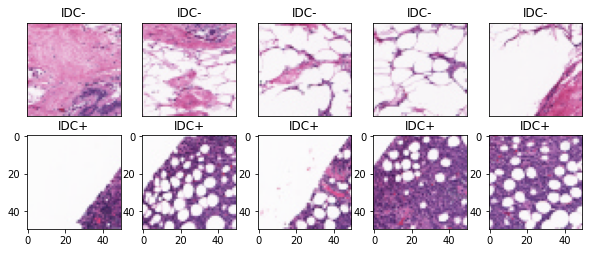

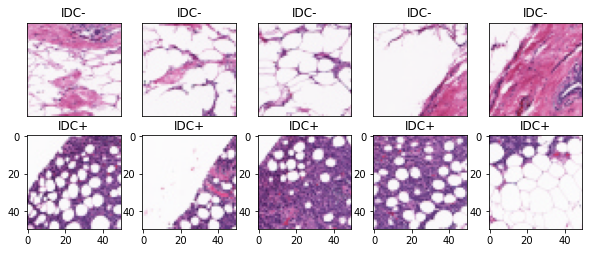

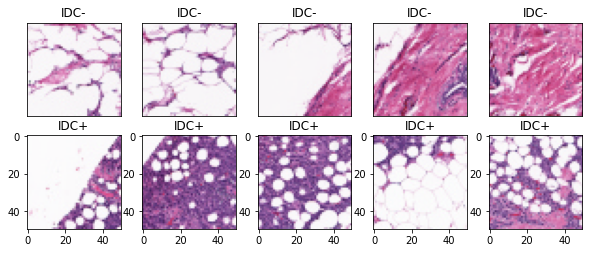

In [0]:
def EDA(X,y):
  print('Number of images: {}'.format(len(X)))
  print('Number of labels: {}'.format(len(y)))
  print('Number of IDC+:{}'.format(np.sum(y==0)))
  print('Number of IDC-:{}'.format(np.sum(y==1)))
  print('Shape of X: {}'.format(X.shape))
  
  PositiveIDCImg = X[y==0]
  NegativeIDCImg = X[y==1]
  for row in range(3):
    plt.figure(figsize=(10,10))
    for col in range(5):
        plt.subplot(5,5,col+1)
        plt.title('IDC-')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(PositiveIDCImg[row+col], cmap=plt.cm.binary)
        plt.subplot(5,5,col+6)
        plt.title('IDC+')
        plt.imshow(NegativeIDCImg[row+col],cmap=plt.cm.binary)


EDA(X,y)

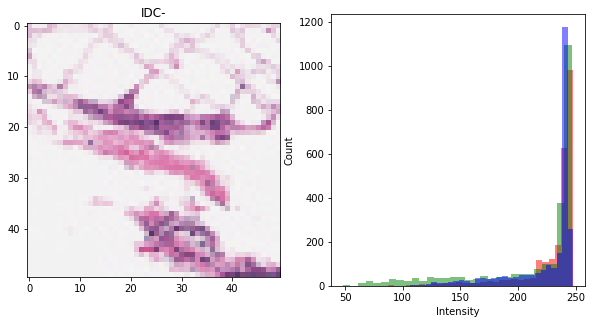

In [0]:
def histoRGB(X):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(X)
  plt.title('IDC+' if y[1] else 'IDC-')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Intensity')
  n_bins=30
  plt.hist(X[:,:,0].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5)
  plt.hist(X[:,:,1].flatten(), bins=n_bins, lw=0, color='g', alpha=0.5)
  plt.hist(X[:,:,2].flatten(), bins=n_bins, lw=0, color='b', alpha=0.5)

histoRGB(X[27])

For training & testing purpose, let's split the data into 2 sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


The scale of the data is from 0 to 256 (RGB) as the histogram plot is showing up above.

Let's turn it to 0 to 1 so we can use a lot more of different algorithms.

In [0]:
X_train.shape

(4437, 50, 50, 3)

In [0]:
X_train = X_train / 256.0
X_test = X_test / 256.0

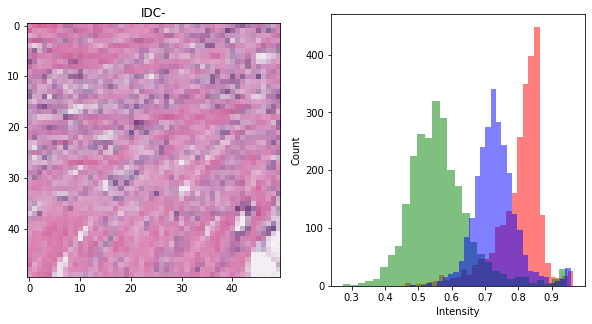

In [0]:
histoRGB(X_train[28])

We can see that the pixel intensity is now on a scale from 0 to 1.

Now we flatten the data by reshaping each image into a 'single line' of data.

The images are now 4437 * 50 * 50 * 3 tensors.
We will flatten them by shaping them into an array of dimension  4437 * 7500 both for test & training

In [0]:
X_train_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_test_shape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_train_flat = X_train.reshape(X_train.shape[0], X_train_shape)
X_test_flat = X_test.reshape(X_test.shape[0], X_test_shape)

Now, let's evaluate different algorithms.


In [0]:
def LogisticRegressionModel(X_train, y_train, X_test, y_test):
  model = LogisticRegression(max_iter = 4000)
  model.fit(X_train,y_train)
  kfold = model_selection.KFold(n_splits=10)
  accuracy = model_selection.cross_val_score(model, X_test,y_test, cv=kfold, scoring='accuracy')
  mean = accuracy.mean()
  stdev = accuracy.std()
  print('Logistic Regression accuracy - Training: %s -- %s'%(mean,stdev) )

LogisticRegressionModel(X_train_flat, y_train, X_test_flat, y_test)

Logistic Regression accuracy - Training: 0.727027027027027 -- 0.05128809127023525


Let's try now different other algorithms

LR: 0.727027 (0.051288)
RF: 0.779279 (0.039935)
KNN: 0.709009 (0.045054)
SVM: 0.768468 (0.040300)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

LSVM: 0.686486 (0.067753)
GNB: 0.727928 (0.033901)
DTC: 0.692793 (0.035912)


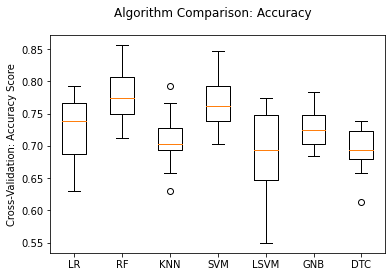

In [0]:
def OtherClassificationAlgoComparison(X_train, y_train, X_test, y_test):
  models = []
  models.append(('LR', LogisticRegression(max_iter = 4000)))
  models.append(('RF', RandomForestClassifier()))
  models.append(('KNN', KNeighborsClassifier()))
  models.append(('SVM', SVC()))
  models.append(('LSVM', LinearSVC(max_iter = 10000)))
  models.append(('GNB', GaussianNB()))
  models.append(('DTC', DecisionTreeClassifier()))
  resultsAccuracy = []
  names = []
  for name, model in models:
      model.fit(X_train, y_train)
      kfold = model_selection.KFold(n_splits=10)
      accuracy_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring='accuracy')
      resultsAccuracy.append(accuracy_results)
      names.append(name)
      accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
      print(accuracyMessage)  
  # boxplot algorithm comparison

  fig = plt.figure()
  fig.suptitle('Algorithm Comparison: Accuracy')
  ax = fig.add_subplot(111)
  plt.boxplot(resultsAccuracy)
  ax.set_xticklabels(names)
  ax.set_ylabel('Cross-Validation: Accuracy Score')
  plt.show()
  return
OtherClassificationAlgoComparison(X_train_flat, y_train, X_test_flat, y_test)


SVM seems promising...

Let's look deeper into the data

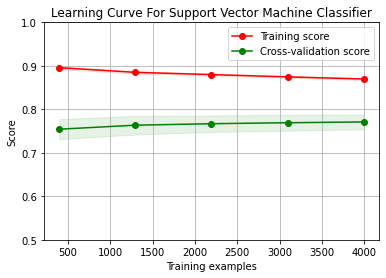

In [0]:
def PlotLearningCurve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def PlotLotsOfLearningCurves(a,b):
    models = []
    models.append(('Support Vector Machine', SVC()))
    models.append(('RF', RandomForestClassifier()))
    for name, model in models:
        PlotLearningCurve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)

PlotLotsOfLearningCurves(X_train_flat, y_train)



Support Vector Machine - Training set accuracy: 0.7684684684684685 (0.040299584227648726) 



<Figure size 432x288 with 0 Axes>

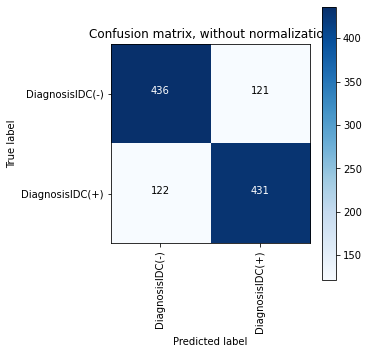

<Figure size 432x288 with 0 Axes>

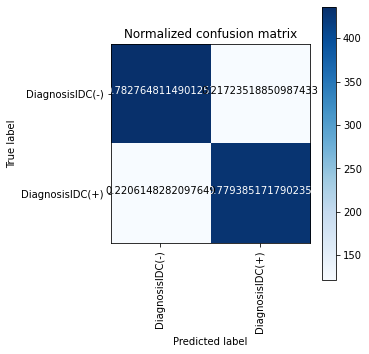

In [0]:
def PlotConfusionMatrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["Diagnosis" "IDC(-)", "Diagnosis" "IDC(+)"]
    plt.figure()
    PlotConfusionMatrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    PlotConfusionMatrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
runSVCconfusion(X_train_flat, y_train, X_test_flat, y_test)
